In [1]:
import matplotlib.pyplot as plt
import matplotlib.collections as clt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from tifffile import imread
import pickle
from skimage.color import label2rgb
from skimage.measure import regionprops
from skimage import measure
from scipy.spatial.distance import cdist
import copy
from sklearn.metrics import confusion_matrix
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 7
        }
padding = {
    'titlepad': 3,
    'labelpad': 1,
}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **padding)

In [3]:
data = pd.read_csv('segmentation_results.csv')
data.head(10)

Dataset  Type  Compression Ratio   
0  20210929_HDCF_R56-8_fibers_6-11_hiRes_NeuN_his...  NeuN               9.20  \
1  20210929_HDCF_R56-8_fibers_6-11_hiRes_NeuN_his...  NeuN              29.10   
2  20210929_HDCF_R56-8_fibers_6-11_hiRes_NeuN_his...  NeuN              51.41   
3  20210929_HDCF_R56-8_fibers_6-11_hiRes_NeuN_his...  NeuN             103.90   
4  20210929_HDCF_R56-8_fibers_6-11_hiRes_NeuN_his...  NeuN             398.50   
5  20211223_HDCF_R54-4_fibers11-16_hiRes_NeuN_his...  NeuN              10.40   
6  20211223_HDCF_R54-4_fibers11-16_hiRes_NeuN_his...  NeuN              29.50   
7  20211223_HDCF_R54-4_fibers11-16_hiRes_NeuN_his...  NeuN              49.80   
8  20211223_HDCF_R54-4_fibers11-16_hiRes_NeuN_his...  NeuN             101.30   
9  20211223_HDCF_R54-4_fibers11-16_hiRes_NeuN_his...  NeuN             611.80   

    Model    Dice  
0  nnUNet  0.9877  
1  nnUNet  0.9861  
2  nnUNet  0.9843  
3  nnUNet  0.9819  
4  nnUNet  0.9604  
5  nnUNet  0.9850  
6  nnUNet  0.9799  
7  nnUNet  0.9762  
8  nnUNet  0.9720  
9  nnUNet  0.9488

In [4]:
datasets = ['20210929_HDCF_R56-8_fibers_6-11_hiRes_NeuN_histMatched_medFilt', 'coord_-5.4,+18.6_2_1X']

In [5]:
toplot = data[data['Model'] == 'nnUNet']
toplot = toplot[toplot['Dataset'].isin(datasets)]

In [6]:
data_path = '/data/duanb/results/segmentation/NeuN/TheFirstnnUNet/'

In [7]:
# samples = {
#     'raw': imread(f'{data_path}{datasets[0]}.tif'),
#     '10': imread(f'{data_path}10/{datasets[0]}.tif'),
#     '30': imread(f'{data_path}30/{datasets[0]}.tif'),
#     '50': imread(f'{data_path}50/{datasets[0]}.tif'),
#     '100': imread(f'{data_path}100/{datasets[0]}.tif'),
#     '400': imread(f'{data_path}400/{datasets[0]}.tif'),
# }

In [8]:
def read_res(x, key=None):
    with open(x, 'rb') as fp: 
        res = pickle.load(fp)
    if key:
        return res[key]
    else:
        return res

In [9]:
def adjust_image(img, gamma=0.5):
    img = img.astype(float)
    img_max = np.amax(img)
    img /= img_max
    img = np.power(img, gamma)
    
    return img

In [10]:
def relabel(seg, ref):
    new_seg = np.zeros_like(seg)
    props = regionprops(seg)
    ref_props = regionprops(ref)
    centriods = np.array([np.array(p.centroid) for p in props])
    ref_centriods = np.array([np.array(p.centroid) for p in ref_props])

    dists = cdist(centriods, ref_centriods)
    ids = np.argmin(dists, axis=-1)
    for i, idx in zip(range(len(ids)), ids):
        new_seg[seg == props[i].label] = ref_props[idx].label

    return new_seg

In [11]:
def to_rgb(mask, colors=list(matplotlib.colors.TABLEAU_COLORS.keys())):
    h, w = mask.shape
    new_mask = np.zeros((h, w, 3))
    for i in np.unique(mask):
        if i == 0:
            new_mask[mask == i] = np.array([0, 0, 0])
        else:
            new_mask[mask == i] = matplotlib.colors.to_rgb(colors[i % len(colors)])
    return new_mask

In [12]:
def plot_mask(ax_handler, mask, img, ref_fg=None):
    if ref_fg is not None:
        mask = measure.label(mask)
        mask = relabel(mask, ref_fg)
    
    mask = to_rgb(mask)
    ax_handler.imshow(img, cmap='gray')
    ax_handler.imshow(mask, alpha=0.7)

In [13]:
def error_image(gt, pred):
    h, w = gt.shape
    mask = np.zeros((h, w, 3))

    # mask[np.logical_and(gt, pred)] = matplotlib.colors.to_rgb('c') # TP
    # mask[np.logical_not(np.logical_and(gt, pred))] = matplotlib.colors.to_rgb('k') # TN
    # mask[np.logical_and(np.logical_not(gt), pred)] = matplotlib.colors.to_rgb('orange') # FP
    # mask[np.logical_and(gt, np.logical_not(pred))] = matplotlib.colors.to_rgb('m') # FN

    mask[np.logical_and(gt, pred)] = matplotlib.colors.to_rgb('c') # TP
    mask[np.logical_and(np.logical_not(gt), pred)] = matplotlib.colors.to_rgb('orange') # FP
    mask[np.logical_and(gt, np.logical_not(pred))] = matplotlib.colors.to_rgb('orange') # FN

    return mask

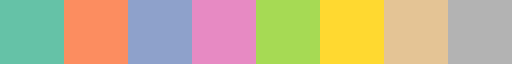

In [14]:
plt.colormaps['Set2']

In [17]:
TP_dist = {'dist': [], 'cx': [], 'cy': [], 'cz': [], 'label': []}
area_data = {'Area': [], 'label': [], 'type': []}
rate_data = {'Error rate': [], 'label': [], 'type': []}

for label in ['10', '30', '50', '100', '400']:
    res = read_res(f'no_thresholds/{datasets[0]}_cs{label}.pkl')

    print(len(res['TP']['dists']), len(res['FN']['area']), len(res['FP']['area']))

    # TP
    for dist, cd in zip(res['TP']['dists'], res['TP']['centroid']):
        TP_dist['dist'].append(dist)
        TP_dist['cx'].append(np.abs(cd[2]))
        TP_dist['cy'].append(np.abs(cd[1]))
        TP_dist['cz'].append(np.abs(cd[0]))
        TP_dist['label'].append(label)
    # FN
    for area in res['FN']['area']:
        area_data['Area'].append(area)
        area_data['label'].append(float(label))
        area_data['type'].append('FN')
        
    rate_data['Error rate'].append(res['FN']['rate'])
    rate_data['label'].append(float(label))
    rate_data['type'].append('FN')

    # FP
    for area in res['FP']['area']:
        area_data['Area'].append(area)
        area_data['label'].append(float(label))
        area_data['type'].append('FP')
    
    rate_data['Error rate'].append(res['FP']['rate'])
    rate_data['label'].append(float(label))
    rate_data['type'].append('FP')

TP_dist = pd.DataFrame(data=TP_dist)
area_data = pd.DataFrame(data=area_data)
rate_data = pd.DataFrame(data=rate_data)

2447 13 240
2434 26 272
2431 29 269
2406 54 253
2350 110 289


In [60]:
area_data = {'size': [], 'label': [], 'type': []}

for label in ['10', '30', '50', '100', '400']:
    res = read_res(f'v3/{datasets[0]}_cs{label}_V3.pkl')
    print(len(res['TP']['dists']), len(res['TP']['num_pixels']), len(res['FN']['num_pixels']), len(res['FP']['num_pixels']))

    # TP
    for area in res['TP']['num_pixels']:
        area_data['size'].append(area * (0.202*0.202*0.5))
        area_data['label'].append(label)
        area_data['type'].append('TP')
    # FN
    for area in res['FN']['num_pixels']:
        area_data['size'].append(area * (0.202*0.202*0.5))
        area_data['label'].append(label)
        area_data['type'].append('FN')

    # FP
    for area in res['FP']['num_pixels']:
        area_data['size'].append(area * (0.202*0.202*0.5))
        area_data['label'].append(label)
        area_data['type'].append('FP')
        
area_data = pd.DataFrame(data=area_data)

2447 2447 13 240
2434 2434 26 272
2431 2431 29 269
2406 2406 54 253
2350 2350 110 289


In [61]:
len(area_data), area_data['size'].max()

(13623, 23691.761294000004)

In [62]:
area_data = area_data[area_data['size'] < area_data['size'].max()]
area_data = area_data[area_data['size'] > 27]
len(area_data)

10178

In [63]:
area_data['size'].max()

12708.058966000002

In [ ]:
fig, axs  = plt.subplots(figsize=(1.6, 1.9), dpi=600, ncols=1, nrows=2, layout='constrained')
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
axs = axs.flat

sns.histplot(data=area_data[area_data['label']=='10'], x="size", hue='type', stat="count", multiple="stack", palette="pastel",ax=axs[0], bins=30)
axs[0].legend([],[], frameon=False)
tmp = area_data[area_data['label']=='10']
TP = len(tmp[tmp['type'] == 'TP'])
FP = len(tmp[tmp['type'] == 'FP'])
FN = len(tmp[tmp['type'] == 'FN'])
print(f"TP: {TP}, FP: {FP}, FN: {FN}")
print(f"TP: {TP/(TP+FP+FN)}, FP: {FP/(TP+FP+FN)}, FN: {FN/(TP+FP+FN)}")
axs[0].set_xlabel('')
# axs[0].set_xlabel('Object Size')
axs[0].set_xticklabels('')

sns.histplot(data=area_data[area_data['label']=='400'], x="size", hue='type', stat="count",  multiple="stack", palette="pastel", ax=axs[1], bins=30)
legend = axs[1].get_legend()
handles = legend.legend_handles
legend.remove()
axs[1].legend(handles, ['TP', 'FN', 'FP'], loc="upper right", frameon=False, fontsize=5)
tmp = area_data[area_data['label']=='400']
TP = len(tmp[tmp['type'] == 'TP'])
FP = len(tmp[tmp['type'] == 'FP'])
FN = len(tmp[tmp['type'] == 'FN'])
print(f"TP: {TP}, FP: {FP}, FN: {FN}")
print(f"TP: {TP/(TP+FP+FN)}, FP: {FP/(TP+FP+FN)}, FN: {FN/(TP+FP+FN)}")

axs[1].sharex(axs[0])
axs[1].sharey(axs[0])
axs[1].set_yscale('log')
axs[1].set_xlabel('Object Size (μm$^3$)')

axs[1].set_xticks([0, 5000, 10000])
axs[1].set_xticklabels([0, '$0.5\\times10^4$', '$1\\times 10^4$'])
# axs[1].set_yticks([1, 10, 100, 1000])
# axs[1].set_yticklabels([1, '$10$', '$100$', '$1000$'])

axs[0].set_title('9.2$\\times$')
axs[1].set_title('398.5$\\times$')

# sns.lineplot(y='Dice', x="Compression Ratio", data=toplot, ax=axs[2], linewidth=1, color=colors[6])

# axs[2].set_xscale('log')
# axs[2].set_xticks([10, 100, 500])
# axs[2].set_xticklabels([10, 100, 500])
# axs[2].set_yticks([0.9, 0.95, 1])
# axs[2].set_ylim(0.9, 1)

# fig.tight_layout()
fig.savefig('metrics_v2.pdf')

TP: 2011, FP: 11, FN: 0
TP: 0.9945598417408507, FP: 0.005440158259149357, FN: 0.0
TP: 2006, FP: 53, FN: 5
TP: 0.9718992248062015, FP: 0.02567829457364341, FN: 0.0024224806201550387


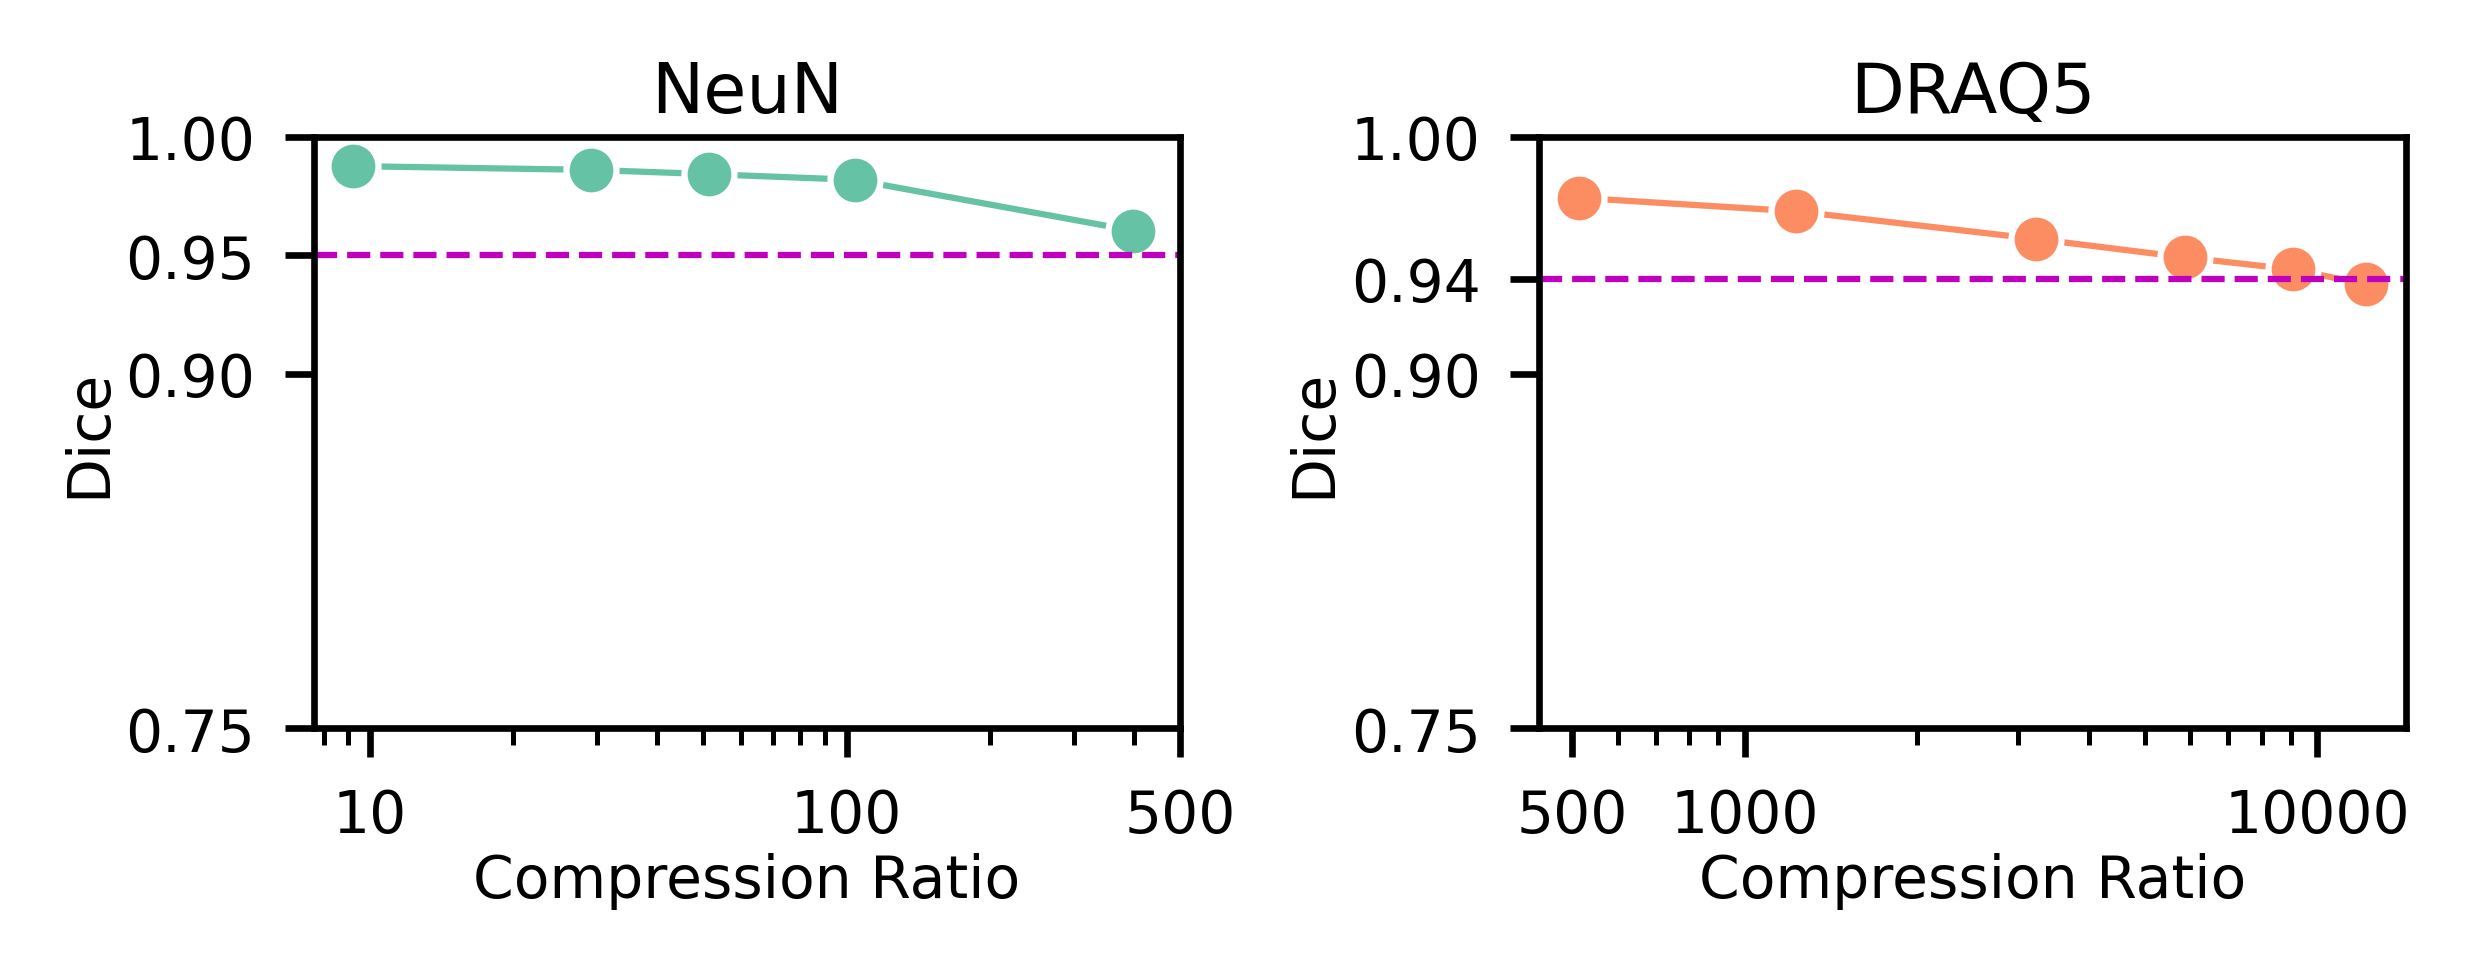

In [26]:
fig, axs  = plt.subplots(figsize=(4, 1.5), dpi=600, ncols=2, nrows=1, layout='constrained')
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
axs = axs.flat

sns.lineplot(y='Dice', x="Compression Ratio", data=toplot[toplot['Type']=='NeuN'], ax=axs[0], marker='o', color=colors[0], lw=0.75)

axs[0].set_xscale('log')
axs[0].set_xticks([10, 100, 500])
axs[0].set_xticklabels([10, 100, 500])
axs[0].set_yticks([0.75, 0.9, 0.95, 1])
axs[0].set_ylim(0.75, 1)
# axs[0].set_xlabel('')

sns.lineplot(y='Dice', x="Compression Ratio", data=toplot[toplot['Type']=='DRAQ5'], ax=axs[1], marker='o', color=colors[1], lw=0.75)

axs[1].set_xscale('log')
axs[1].set_xticks([500, 1000, 10000])
axs[1].set_xticklabels([500, 1000, 10000])
axs[1].set_yticks([0.75, 0.9, 0.94, 1])
axs[1].set_ylim(0.75, 1)

axs[0].set_title('NeuN')
axs[1].set_title('DRAQ5')

axs[0].axhline(0.95, color='m', ls='--', lw=0.75)
axs[1].axhline(0.94, color='m', ls='--', lw=0.75)

fig.savefig('metrics_v4.pdf')

In [27]:
yellowbox = matplotlib.patches.Rectangle((256, 180), 512, 512, linewidth=1, edgecolor='yellow', facecolor='none')
# greenbox = matplotlib.patches.Rectangle((1500, 500), 512, 512, linewidth=1, edgecolor='green', facecolor='none')
redbox = matplotlib.patches.Rectangle((2400, 980), 512, 512, linewidth=1, edgecolor='red', facecolor='none')

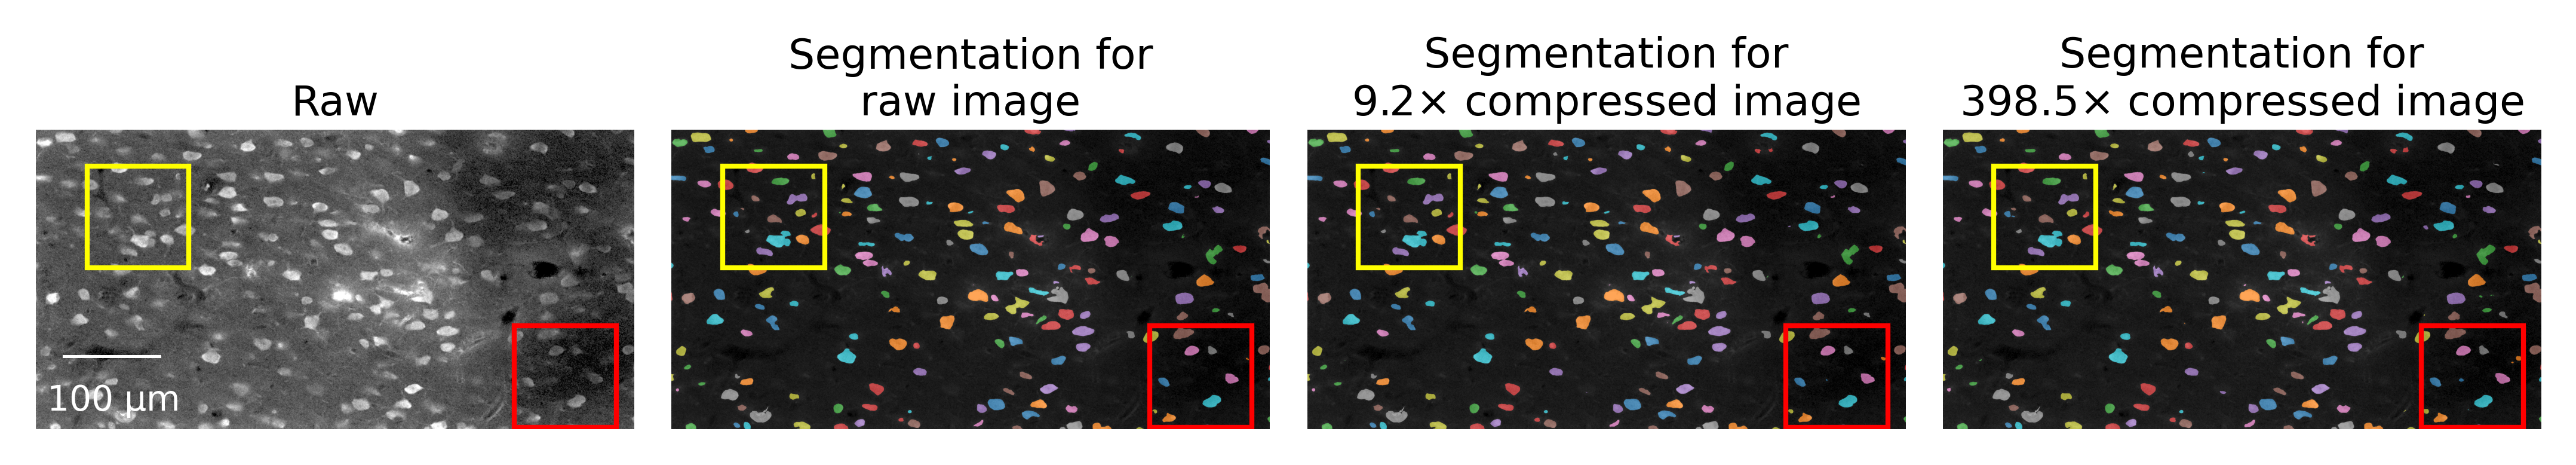

In [28]:
fig, axs = plt.subplots(figsize=(7.2, 2.8), dpi=600, ncols=4, nrows=1, layout='tight')

axs = axs.flat

for i, name in zip(range(4), ['Raw', 'Segmentation for\nraw image', 'Segmentation for\n9.2$\\times$ compressed image', 'Segmentation for\n398.5$\\times$ compressed image']):
    ax = axs[i]
    # ax.add_patch(copy.deepcopy(greenbox))
    ax.add_patch(copy.deepcopy(yellowbox))
    ax.add_patch(copy.deepcopy(redbox))
    
    ax.set_title(name)
    ax.axis('off')


dset1 = adjust_image(imread(f'/data/duanb/NeuN/{datasets[0]}.tif')[400, ...])
axs[0].imshow(dset1, cmap='gray')

ref_fg = measure.label(imread(f'{data_path}{datasets[0]}.tif')[400, ...])
plot_mask(axs[1], ref_fg, dset1)
plot_mask(axs[2], imread(f'{data_path}10/{datasets[0]}.tif')[400, ...], dset1, ref_fg=ref_fg)
plot_mask(axs[3], imread(f'{data_path}400/{datasets[0]}.tif')[400, ...], dset1, ref_fg=ref_fg)
    
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

axs[0].add_artist(ScaleBar(0.202 , 'um', location='lower left', frameon=False, color='w'))
plt.savefig('seg_results1.pdf', bbox_inches='tight')

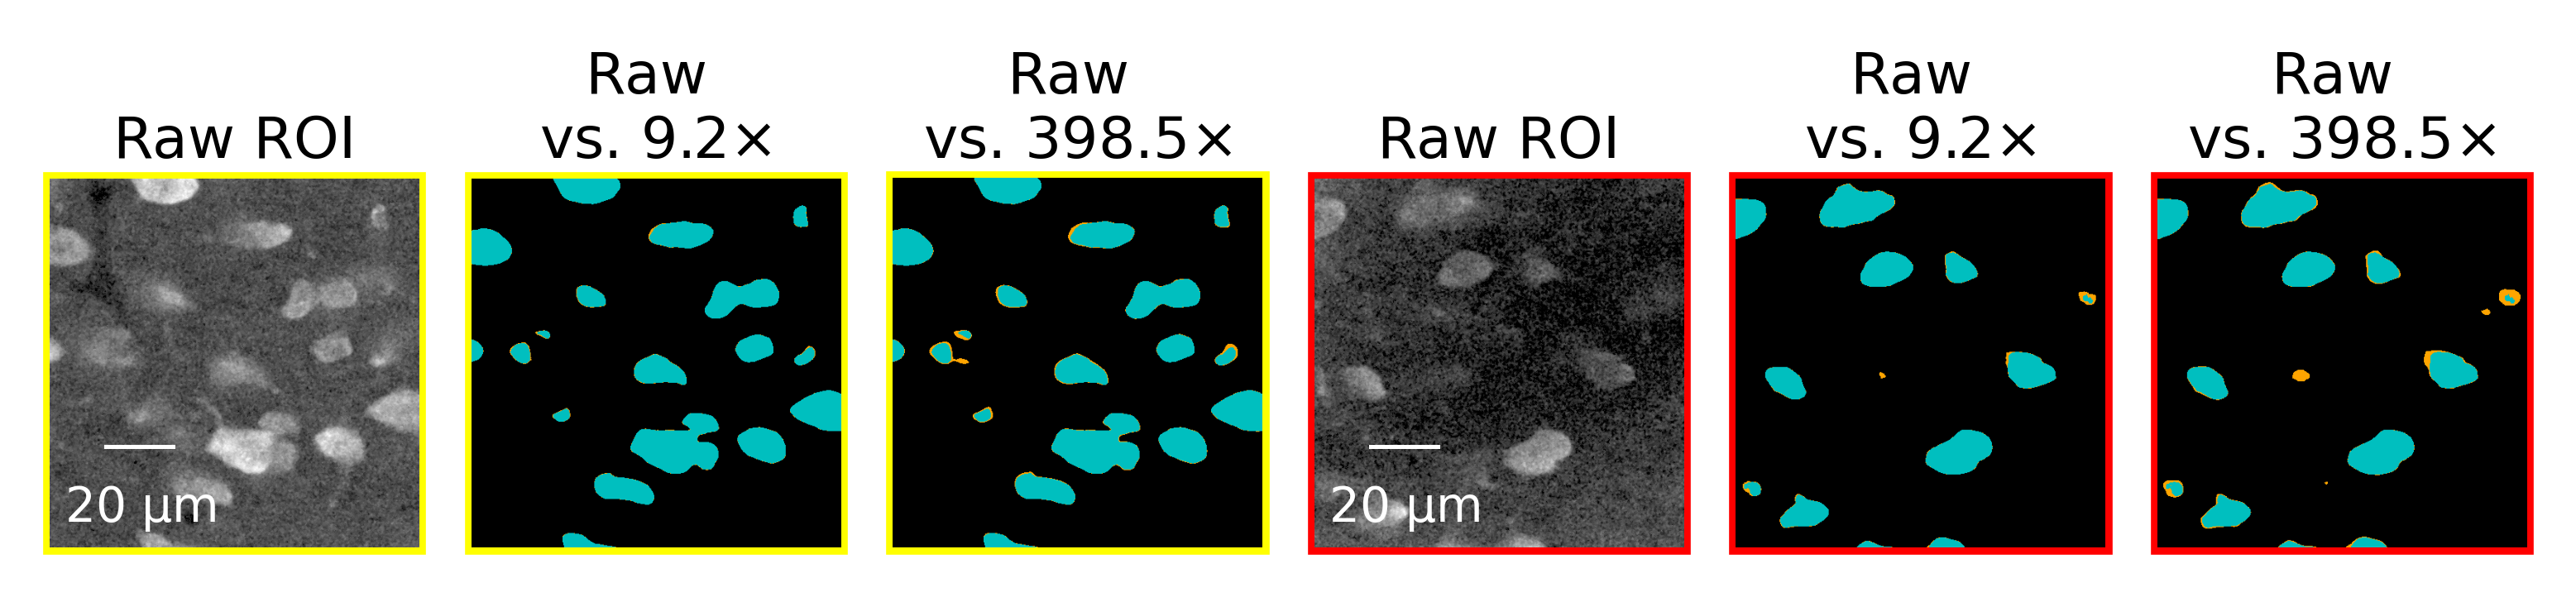

In [15]:
fig, axes = plt.subplots(figsize=(5.2, 3), dpi=600, ncols=6, nrows=1, layout='tight')
axes = axes.flat

for i in range(3):
    ax = axes[i]
    ax.imshow(np.zeros((512, 512)), cmap='gray', vmin=0,vmax=1)
    ax.patch.set_linewidth(2)
    ax.patch.set_edgecolor('yellow')

raw_img = adjust_image(imread(f'/data/duanb/NeuN/{datasets[0]}.tif')[400, 180:180+512, 256:256+512])   
tmp = imread(f'{data_path}{datasets[0]}.tif')[400, 180:180+512, 256:256+512]
tmp_1 = imread(f'{data_path}10/{datasets[0]}.tif')[400, 180:180+512, 256:256+512]
tmp_2 = imread(f'{data_path}400/{datasets[0]}.tif')[400, 180:180+512, 256:256+512]

axes[0].imshow(raw_img, cmap='gray', vmin=0, vmax=np.amax(raw_img))
axes[1].imshow(error_image(tmp, tmp_1))
axes[2].imshow(error_image(tmp, tmp_2))

axes[0].set_title('Raw ROI')
axes[1].set_title('Raw \nvs. 9.2$\\times$')
axes[2].set_title('Raw \nvs. 398.5$\\times$')

# for i in range(3, 6):
#     ax = axes[i]
#     ax.patch.set_linewidth(2)
#     ax.patch.set_edgecolor('green')

# raw_img = adjust_image(imread(f'/data/duanb/NeuN/{datasets[0]}.tif')[400, 500:500+512, 1500:1500+512])
# tmp = imread(f'{data_path}{datasets[0]}.tif')[400, 500:500+512, 1500:1500+512]
# tmp_1 = imread(f'{data_path}10/{datasets[0]}.tif')[400, 500:500+512, 1500:1500+512]
# tmp_2 = imread(f'{data_path}400/{datasets[0]}.tif')[400, 500:500+512, 1500:1500+512]

# axes[3].imshow(raw_img, cmap='gray', vmin=0, vmax=np.amax(raw_img))
# axes[4].imshow(error_image(tmp, tmp_1))
# axes[5].imshow(error_image(tmp, tmp_2))
# axes[3].set_title('Raw patch')
# axes[4].set_title('Raw \nvs.9.2x')
# axes[5].set_title('Raw \nvs.398.5x')

for i in range(3, 6):
    ax = axes[i]
    ax.patch.set_linewidth(2)
    ax.patch.set_edgecolor('red')

raw_img = adjust_image(imread(f'/data/duanb/NeuN/{datasets[0]}.tif')[400, 980:980+512, 2400:2400+512])
tmp = imread(f'{data_path}{datasets[0]}.tif')[400, 980:980+512, 2400:2400+512]
tmp_1 = imread(f'{data_path}10/{datasets[0]}.tif')[400, 980:980+512, 2400:2400+512]
tmp_2 = imread(f'{data_path}400/{datasets[0]}.tif')[400, 980:980+512, 2400:2400+512]

axes[3].imshow(raw_img, cmap='gray', vmin=0, vmax=np.amax(raw_img))
axes[4].imshow(error_image(tmp, tmp_1))
axes[5].imshow(error_image(tmp, tmp_2))
axes[3].set_title('Raw ROI')
axes[4].set_title('Raw \nvs. 9.2$\\times$')
axes[5].set_title('Raw \nvs. 398.5$\\times$')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

axes[0].add_artist(ScaleBar(0.202 , 'um', location='lower left', frameon=False, color='w'))
axes[3].add_artist(ScaleBar(0.202 , 'um', location='lower left', frameon=False, color='w'))
    
plt.savefig('seg_results2.pdf', bbox_inches='tight')

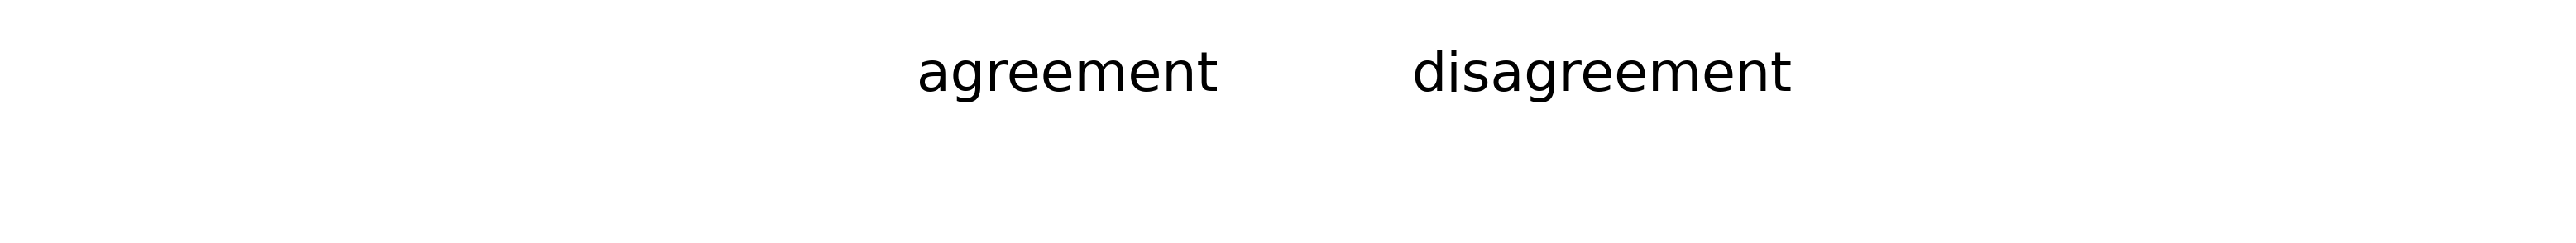

In [30]:
fig, axes = plt.subplots(figsize=(5.2, 0.5), dpi=600, ncols=1, nrows=1, layout='tight')
axes.text(0.35, 1, s='agreement', size=8)
axes.text(0.55, 1, s='disagreement', size=8)
axes.axis('off')
plt.savefig('text.pdf')

In [16]:
import SimpleITK as sitk
data_path = '/data/duanb/results/segmentation/DRAQ5/'

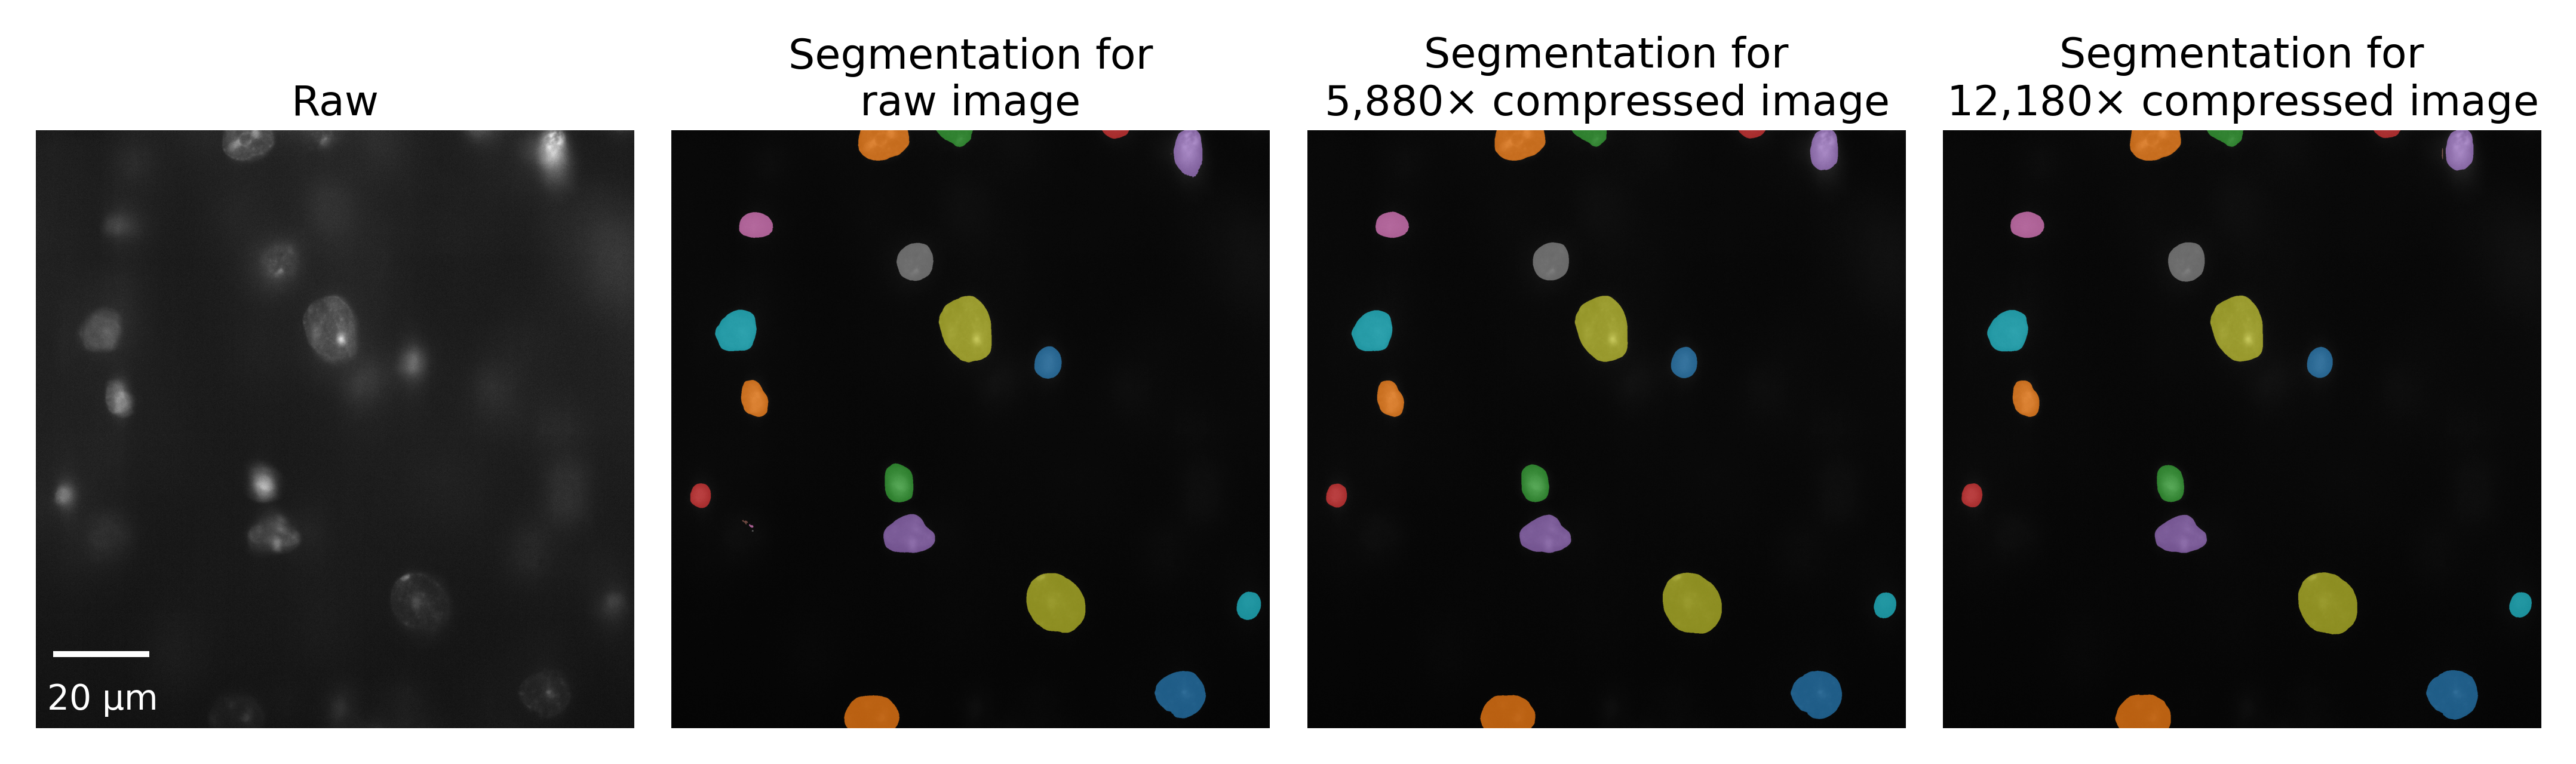

In [17]:
fig, axs = plt.subplots(figsize=(7.2, 2.8), dpi=600, ncols=4, nrows=1, layout='tight')

axs = axs.flat

for i, name in zip(range(4), ['Raw', 'Segmentation for\nraw image', 'Segmentation for\n5,880$\\times$ compressed image', 'Segmentation for\n12,180$\\times$ compressed image']):
    ax = axs[i]
    
    ax.set_title(name)
    ax.axis('off')


dset1 = adjust_image(imread(f'/data/duanb/DRAQ5/{datasets[1]}.tif')[750, ...], 0.8)
axs[0].imshow(dset1, cmap='gray')

ref_fg = measure.label(sitk.GetArrayFromImage(sitk.ReadImage(f'{data_path}/raw/{datasets[1]}.nii.gz'))[750, ...])
plot_mask(axs[1], ref_fg, dset1)
plot_mask(axs[2], sitk.GetArrayFromImage(sitk.ReadImage(f'{data_path}/with_filmgrain/5880/{datasets[1]}.nii.gz'))[750, ...], dset1, ref_fg=ref_fg)
plot_mask(axs[3], sitk.GetArrayFromImage(sitk.ReadImage(f'{data_path}/with_filmgrain/12180/{datasets[1]}.nii.gz'))[750, ...], dset1, ref_fg=ref_fg)
    
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

axs[0].add_artist(ScaleBar(100/1.8 , 'nm', location='lower left', frameon=False, color='w'))
plt.savefig('seg_results3.pdf', bbox_inches='tight')

In [52]:
area_data = {'size': [], 'label': [], 'type': []}

for label in ['5880', '12180']:
    res = read_res(f'DRAQ5/{datasets[1]}_cs{label}.pkl')
    print(len(res['TP']['dists']), len(res['TP']['num_pixels']), len(res['FN']['num_pixels']), len(res['FP']['num_pixels']))

    # TP
    for area in res['TP']['num_pixels']:
        area_data['size'].append(area * (0.1*0.1*0.5))
        area_data['label'].append(label)
        area_data['type'].append('TP')
    # FN
    for area in res['FN']['num_pixels']:
        area_data['size'].append(area * (0.1*0.1*0.5))
        area_data['label'].append(label)
        area_data['type'].append('FN')

    # FP
    for area in res['FP']['num_pixels']:
        area_data['size'].append(area * (0.1*0.1*0.5))
        area_data['label'].append(label)
        area_data['type'].append('FP')
        
area_data = pd.DataFrame(data=area_data)

334 334 60 12
334 334 60 28


In [53]:
area_data = area_data[area_data['size'] < area_data['size'].max()]
area_data = area_data[area_data['size'] > (27*1.8**3)]
len(area_data)

654

TP: 319, FP: 0, FN: 8
TP: 0.9755351681957186, FP: 0.0, FN: 0.024464831804281346
TP: 318, FP: 0, FN: 9
TP: 0.9724770642201835, FP: 0.0, FN: 0.027522935779816515


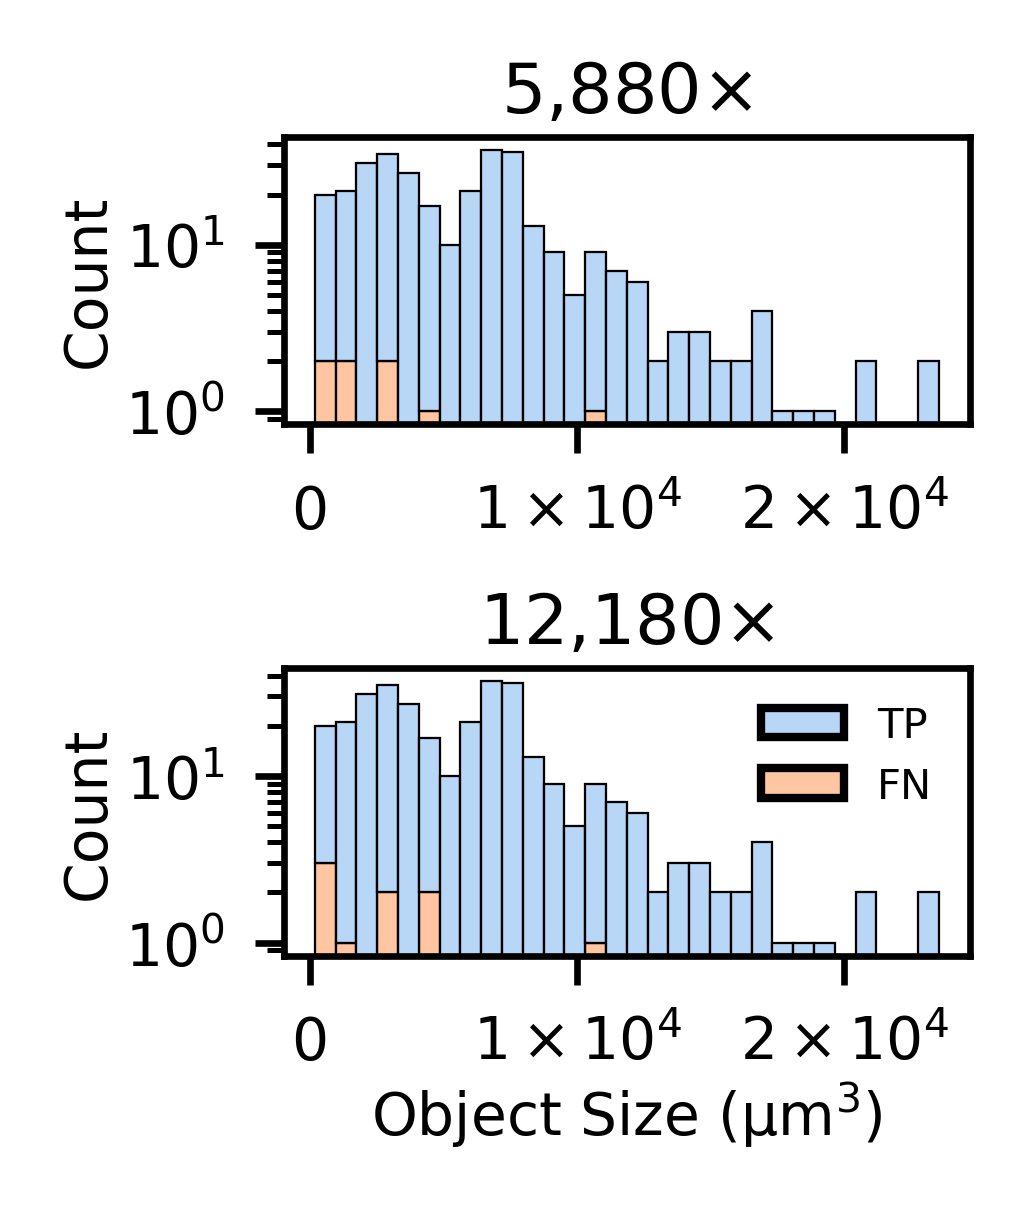

In [54]:
fig, axs  = plt.subplots(figsize=(1.6, 1.9), dpi=600, ncols=1, nrows=2, layout='constrained')
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
axs = axs.flat

sns.histplot(data=area_data[area_data['label']=='5880'], x="size", hue='type', stat="count", multiple="stack", palette="pastel",ax=axs[0], bins=30)
axs[0].legend([],[], frameon=False)
axs[0].set_xlabel('')
tmp = area_data[area_data['label']=='5880']
TP = len(tmp[tmp['type'] == 'TP'])
FP = len(tmp[tmp['type'] == 'FP'])
FN = len(tmp[tmp['type'] == 'FN'])
print(f"TP: {TP}, FP: {FP}, FN: {FN}")
print(f"TP: {TP/(TP+FP+FN)}, FP: {FP/(TP+FP+FN)}, FN: {FN/(TP+FP+FN)}")
# axs[0].set_xlabel('Object Size')
# axs[0].set_xticklabels('')

sns.histplot(data=area_data[area_data['label']=='12180'], x="size", hue='type', stat="count",  multiple="stack", palette="pastel", ax=axs[1], bins=30)
# axs[1].legend([],[], frameon=False)
tmp = area_data[area_data['label']=='12180']
TP = len(tmp[tmp['type'] == 'TP'])
FP = len(tmp[tmp['type'] == 'FP'])
FN = len(tmp[tmp['type'] == 'FN'])
print(f"TP: {TP}, FP: {FP}, FN: {FN}")
print(f"TP: {TP/(TP+FP+FN)}, FP: {FP/(TP+FP+FN)}, FN: {FN/(TP+FP+FN)}")
legend = axs[1].get_legend()
handles = legend.legend_handles
legend.remove()
axs[1].legend(handles, ['TP', 'FN', 'FP'], loc="upper right", frameon=False, fontsize=5)

axs[1].sharex(axs[0])
axs[1].sharey(axs[0])
axs[1].set_yscale('log')
axs[1].set_xlabel('Object Size (μm$^3$)')

axs[1].set_xticks([0, 10000, 20000])
axs[1].set_xticklabels([0, '$1\\times10^4$', '$2\\times 10^4$'])

# axs[1].set_yticks([1, 10, 100])
# axs[1].set_yticklabels([1, '$10$', '$100$'])

axs[0].set_title('5,880$\\times$')
axs[1].set_title('12,180$\\times$')

# sns.lineplot(y='Dice', x="Compression Ratio", data=toplot, ax=axs[2], linewidth=1, color=colors[6])

# axs[2].set_xscale('log')
# axs[2].set_xticks([10, 100, 500])
# axs[2].set_xticklabels([10, 100, 500])
# axs[2].set_yticks([0.9, 0.95, 1])
# axs[2].set_ylim(0.9, 1)

# fig.tight_layout()
fig.savefig('metrics_v3.pdf')

In [21]:
TP_dist = {'dist': [], 'cx': [], 'cy': [], 'cz': [], 'label': []}
area_data = {'Area': [], 'label': [], 'type': []}
rate_data = {'Error rate': [], 'label': [], 'type': []}

for label in ['5880', '12180']:
    res = read_res(f'DRAQ5/{datasets[1]}_cs{label}.pkl')

    # TP
    for dist, cd in zip(res['TP']['dists'], res['TP']['centroid']):
        TP_dist['dist'].append(dist)
        TP_dist['cx'].append(np.abs(cd[2]))
        TP_dist['cy'].append(np.abs(cd[1]))
        TP_dist['cz'].append(np.abs(cd[0]))
        TP_dist['label'].append(label)

TP_dist = pd.DataFrame(data=TP_dist)

In [148]:
TP_dist = {'dist': [], 'label': []}

for label in ['10', '100', '400']:
    res = read_res(f'no_thresholds/{datasets[0]}_cs{label}.pkl')

    print(len(res['TP']['dists']), len(res['FN']['area']), len(res['FP']['area']))

    # TP
    for dist, cd in zip(res['TP']['dists'], res['TP']['centroid']):
        TP_dist['dist'].append(dist*0.202)
        TP_dist['label'].append(label)
    

TP_dist = pd.DataFrame(data=TP_dist)

2447 13 240
2406 54 253
2350 110 289


96%
94%
88%


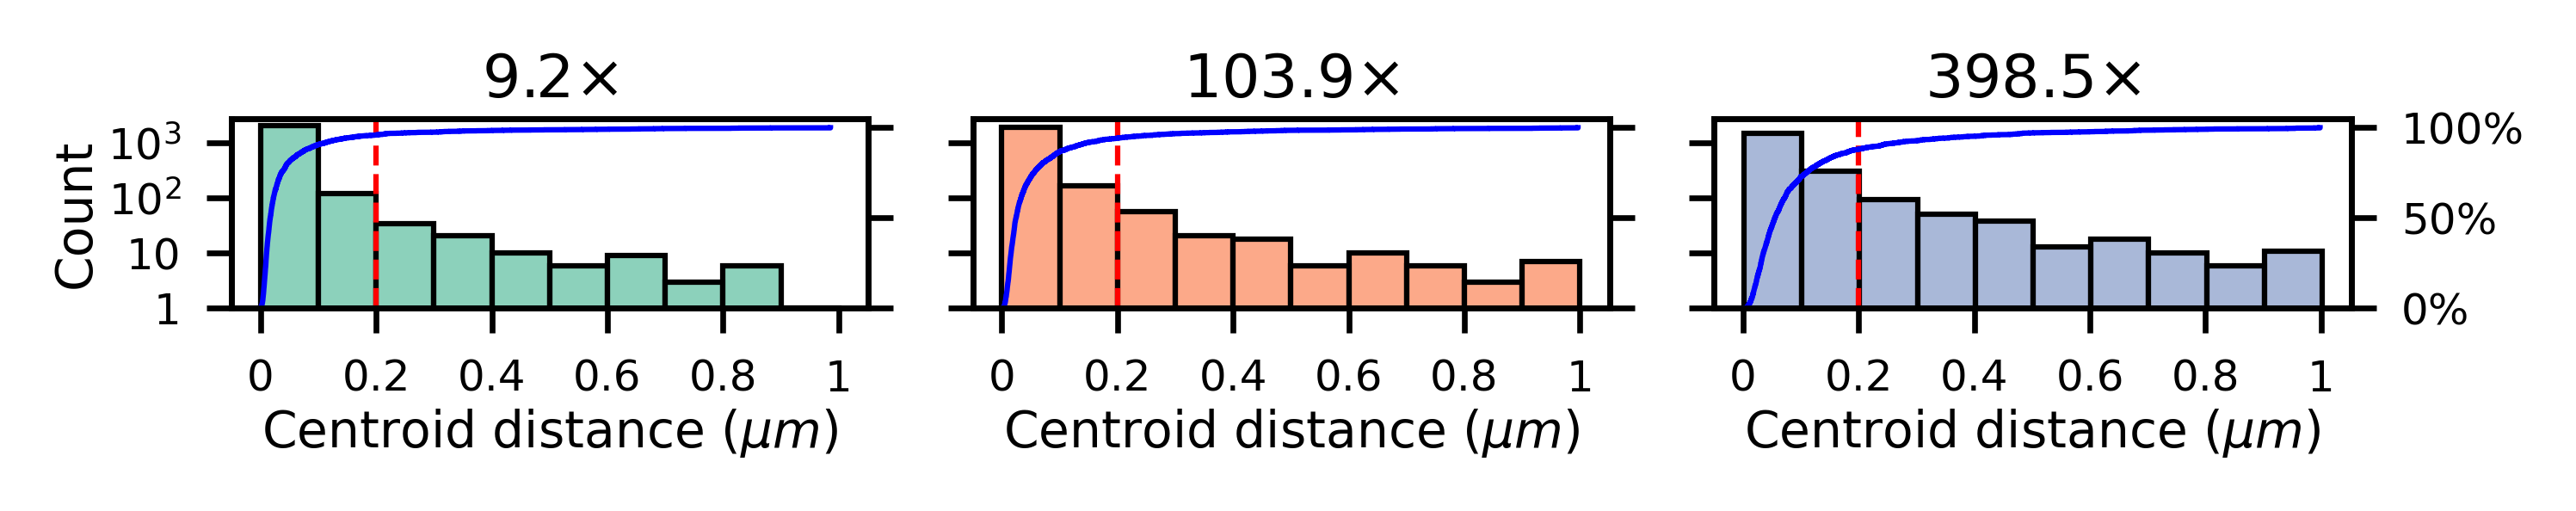

In [149]:
fig, axs  = plt.subplots(figsize=(5, 1), dpi=600, ncols=3, nrows=1, sharex=True, sharey=True)
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
axs = axs.flat
axs_twins = []

TP_dist=TP_dist[np.abs(TP_dist['dist']) <= 1]

for i, la in zip(range(3), ['10', '100', '400']):
    ax = axs[i]
    ax_twin = ax.twinx()
    
    axs_twins.append(ax_twin)
    sns.histplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax, color=colors[i % 3], binwidth=0.1)
    sns.ecdfplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax_twin, color='b', linewidth=0.75)
    ax.axvline(x=0.2, color='r', ls='--', lw=0.75)
    tmp = TP_dist[TP_dist['label']==la]
    print(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}')
    # ax_twin.annotate(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}', (0.2,0.88),
                # xytext=(0, 4),  # 4 points vertical offset.
                # textcoords='offset points',
                # ha='center', va='bottom')

for ax, ax_twin in zip(axs, axs_twins):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_yticks([1, 10, 100, 1000], [1, 10, '$10^2$', '$10^3$'], fontsize=6)
    # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=6)
    # ax.set_xticklabels('')
    # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=6)

    ax_twin.set_ylabel('')
    ax_twin.set_yticklabels('')

for i, ax_twin in zip(range(len(axs_twins)), axs_twins):
    ax_twin.set_ylim(0, 1.05)
    ax_twin.set_yticks([0, 0.5, 1], ['', '', ''], fontsize=6)

axs_twins[2].set_yticks([0, 0.5, 1], ['0%', '50%', '100%'], fontsize=6)

axs[0].set_title('9.2$\\times$')
axs[1].set_title('103.9$\\times$')
axs[2].set_title('398.5$\\times$')
axs[0].set_ylabel('Count')

axs[0].set_xlabel('Centroid distance ($\mu m$)')
axs[1].set_xlabel('Centroid distance ($\mu m$)')
axs[2].set_xlabel('Centroid distance ($\mu m$)')

# axs[2].set_xlabel('Centroid distance ($\mu m$)')

fig.tight_layout()
fig.savefig('NeuN.png')

In [146]:
TP_dist = {'dist': [], 'label': []}
area_data = {'Area': [], 'label': [], 'type': []}
rate_data = {'Error rate': [], 'label': [], 'type': []}

for label in ['2700', '5880', '11627']:
    res = read_res(f'DRAQ5_nofilmgrain/{datasets[1]}_cs{label}.pkl')

    # TP
    for dist, cd in zip(res['TP']['dists'], res['TP']['centroid']):
        TP_dist['dist'].append(dist*0.1/1.8)
        TP_dist['label'].append(label)

TP_dist = pd.DataFrame(data=TP_dist)

84%
81%
71%


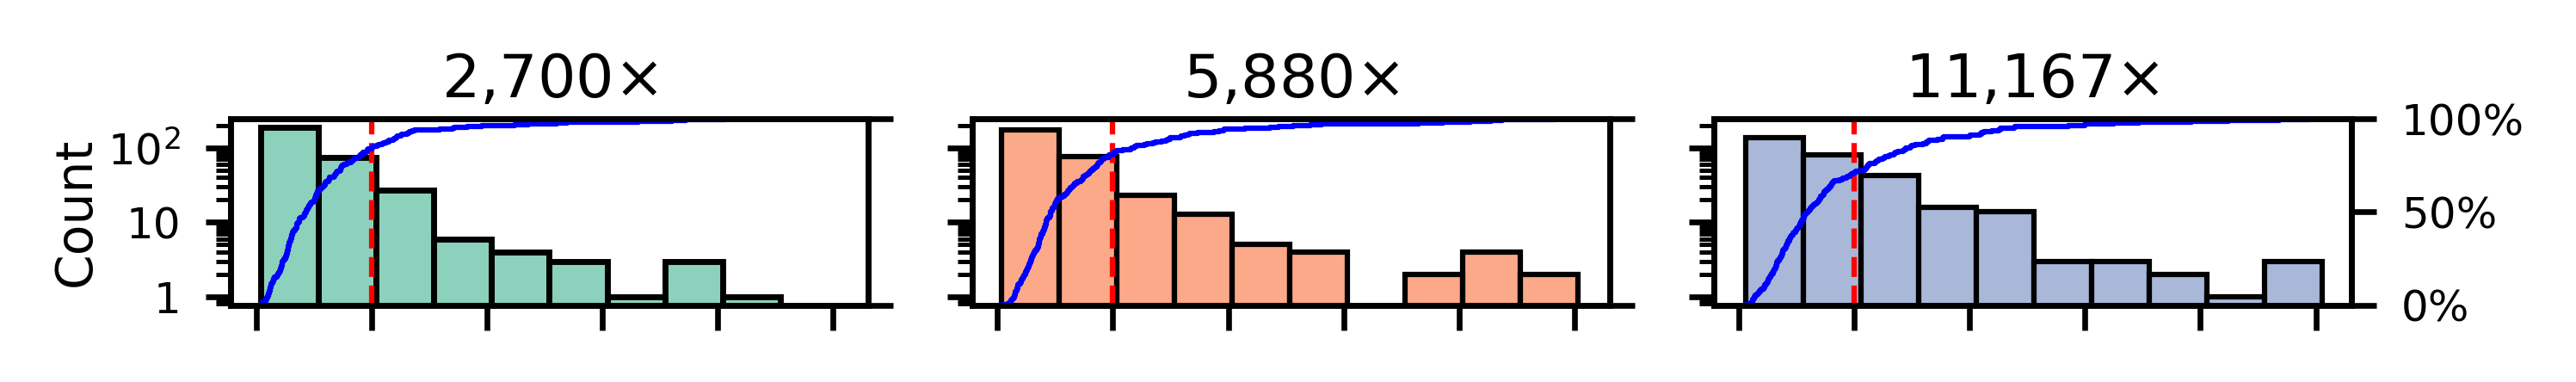

In [147]:
fig, axs  = plt.subplots(figsize=(5, 0.75), dpi=600, ncols=3, nrows=1, sharex=True, sharey=True)
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
axs = axs.flat
axs_twins = []

TP_dist=TP_dist[np.abs(TP_dist['dist']) <= 1]

for i, la in zip(range(3), ['2700', '5880', '11627']):
    ax = axs[i]
    ax_twin = ax.twinx()
    axs_twins.append(ax_twin)
    sns.histplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax, color=colors[i % 3], binwidth=0.1)
    sns.ecdfplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax_twin, color='b', linewidth=0.75)
    ax.axvline(x=0.2, color='r', ls='--', lw=0.75)
    tmp = TP_dist[TP_dist['label']==la]
    print(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}')
    # ax_twin.annotate(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}', (0.2,0.88),
    #             xytext=(0, 4),  # 4 points vertical offset.
    #             textcoords='offset points',
    #             ha='center', va='bottom')

for ax, ax_twin in zip(axs, axs_twins):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticklabels('')
    ax.set_yticks([1, 10, 100], [1, 10, '$10^2$'], fontsize=6)
    # ax.set_xscale('log')

    ax_twin.set_ylabel('')
    ax_twin.set_yticklabels('')

axs[0].set_title('2,700$\\times$')
axs[1].set_title('5,880$\\times$')
axs[2].set_title('11,167$\\times$')

axs_twins[2].set_yticks([0, 0.5, 1], ['0%', '50%', '100%'], fontsize=6)

axs[0].set_xlabel('')
# axs[1].set_xlabel('Centroid distance ($\mu m$)')
# for i in [0, 3, 6]:
#     axs[i].set_xticks([0.1, 1, 10, 100])
#     axs[i].set_xticklabels([0.1, 1, 10, ''])

# axs[0].set_ylabel('x')
# axs[2].set_ylabel('y')
# axs[4].set_ylabel('z')

axs[0].set_ylabel('Count')
# axs_twins[2].set_ylabel('proportion')
# axs_twins[5].set_ylabel('proportion')
# axs_twins[8].set_ylabel('proportion')

# axs_twins[2].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[5].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[8].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[2].set_yticklabels([0, 0.5, 0.93, 1])
# axs_twins[5].set_yticklabels([0, 0.5, 0.93, 1])
# axs_twins[8].set_yticklabels([0, 0.5, 0.93, 1])

fig.tight_layout()
fig.savefig('DRAQ5_nograin.png')

In [144]:
TP_dist = {'dist': [], 'label': []}
area_data = {'Area': [], 'label': [], 'type': []}
rate_data = {'Error rate': [], 'label': [], 'type': []}

for label in ['3230', '5880', '12180']:
    res = read_res(f'DRAQ5/{datasets[1]}_cs{label}.pkl')

    # TP
    for dist, cd in zip(res['TP']['dists'], res['TP']['centroid']):
        TP_dist['dist'].append(dist*0.1/1.8)
        TP_dist['label'].append(label)

TP_dist = pd.DataFrame(data=TP_dist)

92%
90%
86%


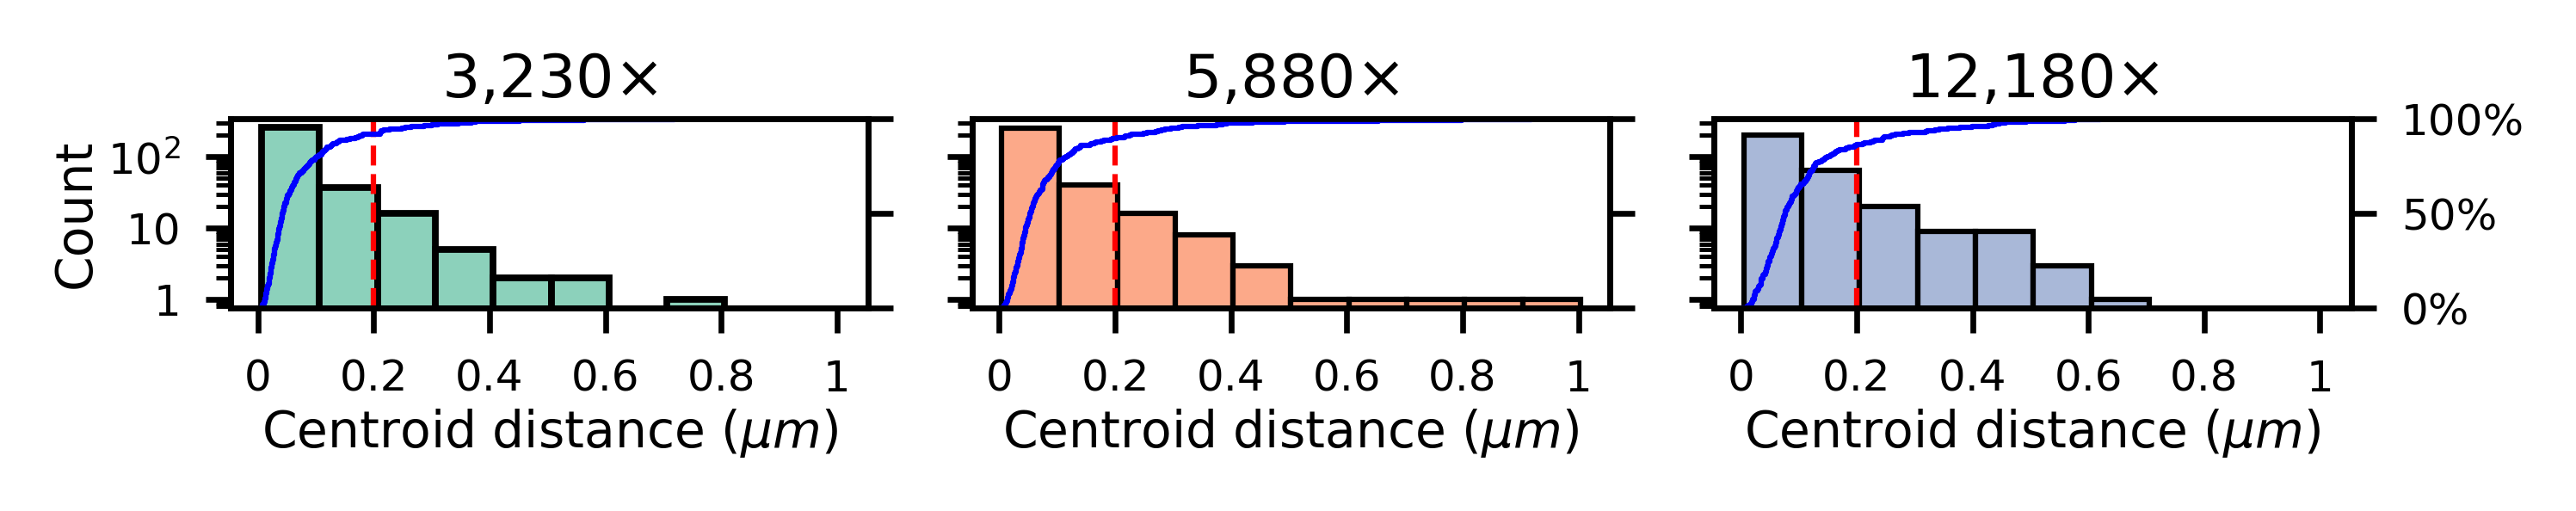

In [145]:
fig, axs  = plt.subplots(figsize=(5, 1), dpi=600, ncols=3, nrows=1, sharex=True, sharey=True)
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
axs = axs.flat
axs_twins = []

TP_dist=TP_dist[np.abs(TP_dist['dist']) <= 1]

for i, la in zip(range(3), ['3230', '5880', '12180']):
    ax = axs[i]
    ax_twin = ax.twinx()
    axs_twins.append(ax_twin)
    sns.histplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax, color=colors[i % 3], binwidth=0.1)
    sns.ecdfplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax_twin, color='b', linewidth=0.75)
    ax.axvline(x=0.2, color='r', ls='--', lw=0.75)
    tmp = TP_dist[TP_dist['label']==la]
    print(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}')
    # ax_twin.annotate(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}', (0.2,0.88),
    #             xytext=(0, 4),  # 4 points vertical offset.
    #             textcoords='offset points',
    #             ha='center', va='bottom')

for ax, ax_twin in zip(axs, axs_twins):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    # ax.set_xticklabels('')
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=6)
    ax.set_yticks([1, 10, 100], [1, 10, '$10^2$'], fontsize=6)
    # ax.set_xscale('log')

    ax_twin.set_ylabel('')
    ax_twin.set_yticks([0, 0.5, 1])
    ax_twin.set_yticklabels('')

axs[0].set_title('3,230$\\times$')
axs[1].set_title('5,880$\\times$')
axs[2].set_title('12,180$\\times$')

axs[0].set_xlabel('Centroid distance ($\mu m$)')
axs[1].set_xlabel('Centroid distance ($\mu m$)')
axs[2].set_xlabel('Centroid distance ($\mu m$)')

axs_twins[2].set_yticks([0, 0.5, 1], ['0%', '50%', '100%'], fontsize=6)
# for i in [0, 3, 6]:
#     axs[i].set_xticks([0.1, 1, 10, 100])
#     axs[i].set_xticklabels([0.1, 1, 10, ''])

# axs[0].set_ylabel('x')
# axs[2].set_ylabel('y')
# axs[4].set_ylabel('z')

# axs_twins[2].set_ylabel('proportion')
# axs_twins[5].set_ylabel('proportion')
# axs_twins[8].set_ylabel('proportion')

# axs_twins[2].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[5].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[8].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[2].set_yticklabels([0, 0.5, 0.93, 1])
# axs_twins[5].set_yticklabels([0, 0.5, 0.93, 1])
# axs_twins[8].set_yticklabels([0, 0.5, 0.93, 1])
axs[0].set_ylabel('Count')

fig.tight_layout()
fig.savefig('DRAQ5.png')

In [27]:
TP_dist = {'dist': [], 'label': [], 'area': []}
area_data = {'Area': [], 'label': [], 'type': []}
rate_data = {'Error rate': [], 'label': [], 'type': []}

for label in ['2700', '5880', '11627']:
    res = read_res(f'DRAQ5_nofilmgrain/{datasets[1]}_cs{label}.pkl')

    # TP
    for dist, cd, area in zip(res['TP']['dists'], res['TP']['centroid'], res['TP']['num_pixels']):
        TP_dist['dist'].append(dist*0.1/1.8)
        TP_dist['label'].append(label)
        TP_dist['area'].append(area)

TP_dist = pd.DataFrame(data=TP_dist)

913 910
84%
81%
71%


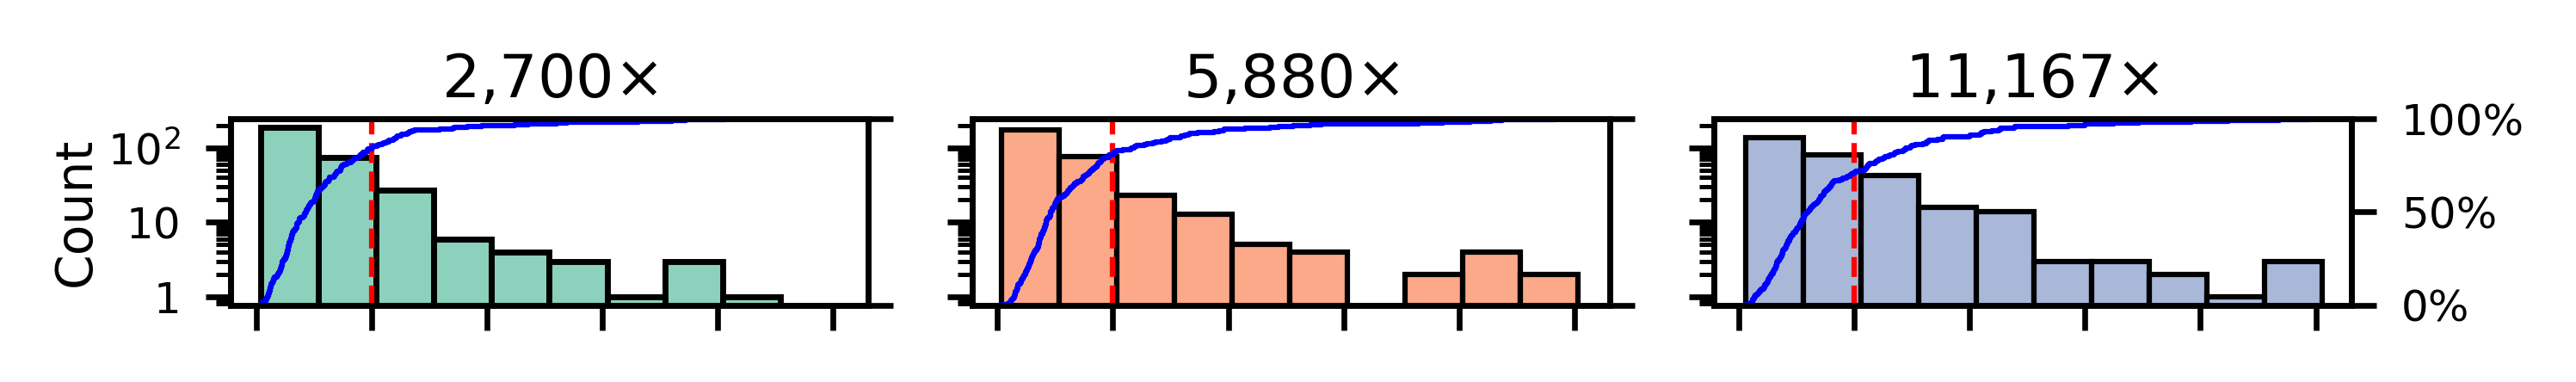

In [28]:
fig, axs  = plt.subplots(figsize=(5, 0.75), dpi=600, ncols=3, nrows=1, sharex=True, sharey=True)
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
axs = axs.flat
axs_twins = []

TP_dist=TP_dist[np.abs(TP_dist['dist']) <= 1]
print(len(TP_dist), len(TP_dist[TP_dist['area'] >= 5**3*1.8**3]))
# TP_dist=TP_dist[TP_dist['area'] >= 5**3*1.8**3]

for i, la in zip(range(3), ['2700', '5880', '11627']):
    ax = axs[i]
    ax_twin = ax.twinx()
    axs_twins.append(ax_twin)
    sns.histplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax, color=colors[i % 3], binwidth=0.1)
    sns.ecdfplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax_twin, color='b', linewidth=0.75)
    ax.axvline(x=0.2, color='r', ls='--', lw=0.75)
    tmp = TP_dist[TP_dist['label']==la]
    print(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}')
    # ax_twin.annotate(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}', (0.2,0.88),
    #             xytext=(0, 4),  # 4 points vertical offset.
    #             textcoords='offset points',
    #             ha='center', va='bottom')

for ax, ax_twin in zip(axs, axs_twins):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticklabels('')
    ax.set_yticks([1, 10, 100], [1, 10, '$10^2$'], fontsize=6)
    # ax.set_xscale('log')

    ax_twin.set_ylabel('')
    ax_twin.set_yticklabels('')

axs[0].set_title('2,700$\\times$')
axs[1].set_title('5,880$\\times$')
axs[2].set_title('11,167$\\times$')

axs_twins[2].set_yticks([0, 0.5, 1], ['0%', '50%', '100%'], fontsize=6)

axs[0].set_xlabel('')
# axs[1].set_xlabel('Centroid distance ($\mu m$)')
# for i in [0, 3, 6]:
#     axs[i].set_xticks([0.1, 1, 10, 100])
#     axs[i].set_xticklabels([0.1, 1, 10, ''])

# axs[0].set_ylabel('x')
# axs[2].set_ylabel('y')
# axs[4].set_ylabel('z')

axs[0].set_ylabel('Count')
# axs_twins[2].set_ylabel('proportion')
# axs_twins[5].set_ylabel('proportion')
# axs_twins[8].set_ylabel('proportion')

# axs_twins[2].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[5].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[8].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[2].set_yticklabels([0, 0.5, 0.93, 1])
# axs_twins[5].set_yticklabels([0, 0.5, 0.93, 1])
# axs_twins[8].set_yticklabels([0, 0.5, 0.93, 1])

fig.tight_layout()
fig.savefig('DRAQ5_nograin_5um.png')

In [29]:
TP_dist = {'dist': [], 'label': [], 'area': []}
area_data = {'Area': [], 'label': [], 'type': []}
rate_data = {'Error rate': [], 'label': [], 'type': []}

for label in ['3230', '5880', '12180']:
    res = read_res(f'DRAQ5/{datasets[1]}_cs{label}.pkl')

    for dist, cd, area in zip(res['TP']['dists'], res['TP']['centroid'], res['TP']['num_pixels']):
        TP_dist['dist'].append(dist*0.1/1.8)
        TP_dist['label'].append(label)
        TP_dist['area'].append(area)

TP_dist = pd.DataFrame(data=TP_dist)

956 951
92%
90%
86%


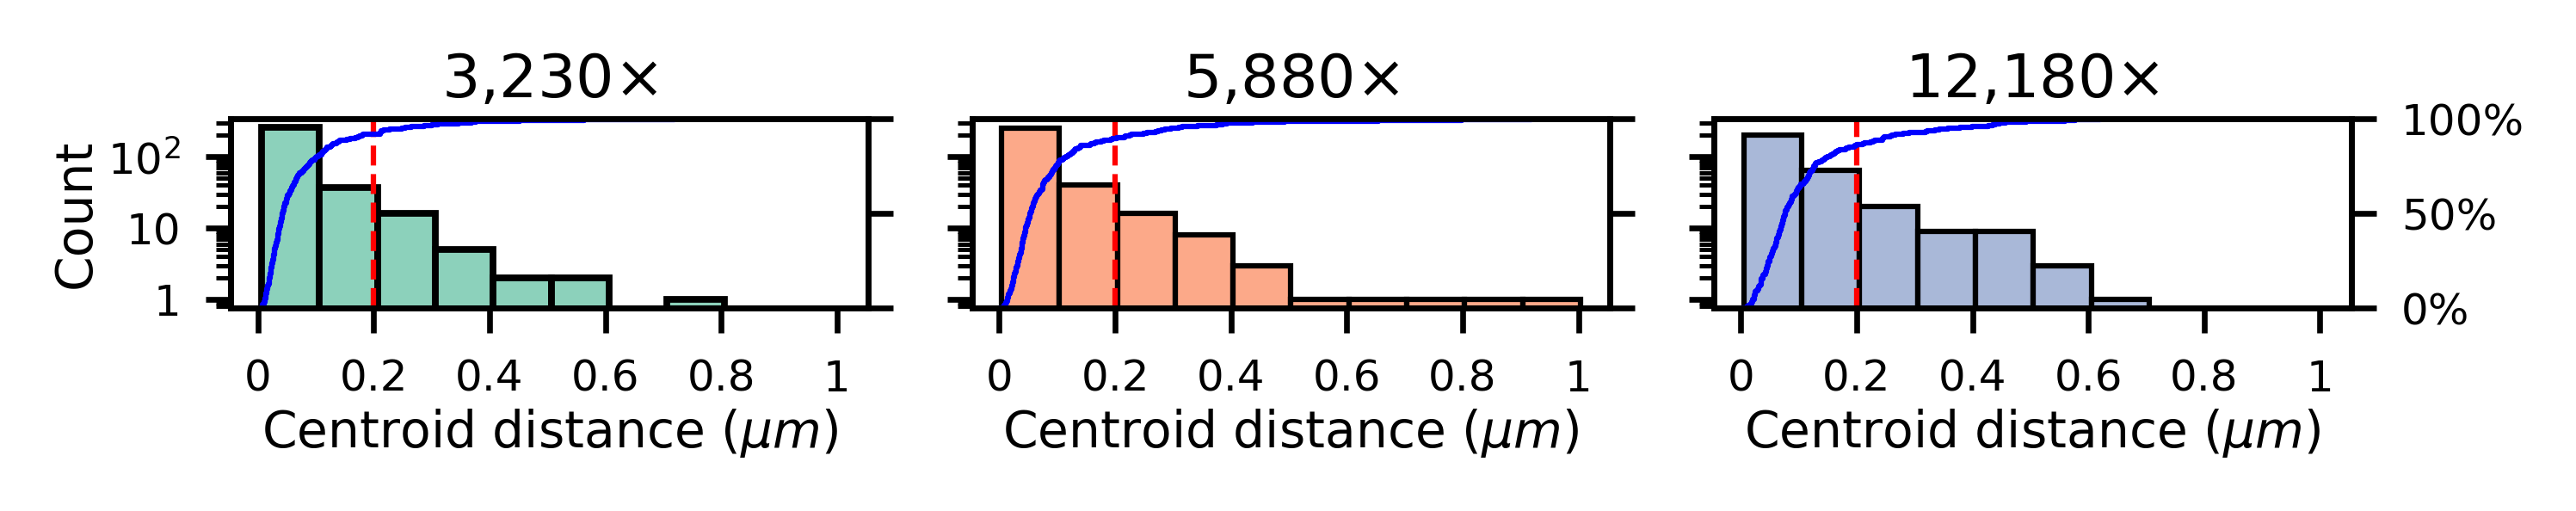

In [30]:
fig, axs  = plt.subplots(figsize=(5, 1), dpi=600, ncols=3, nrows=1, sharex=True, sharey=True)
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
axs = axs.flat
axs_twins = []

TP_dist=TP_dist[np.abs(TP_dist['dist']) <= 1]
print(len(TP_dist), len(TP_dist[TP_dist['area'] >= 5**3*1.8**3]))
# TP_dist=TP_dist[TP_dist['area'] >= 5**3*1.8**3]

for i, la in zip(range(3), ['3230', '5880', '12180']):
    ax = axs[i]
    ax_twin = ax.twinx()
    axs_twins.append(ax_twin)
    sns.histplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax, color=colors[i % 3], binwidth=0.1)
    sns.ecdfplot(data=TP_dist[TP_dist['label']==la], x='dist', ax=ax_twin, color='b', linewidth=0.75)
    ax.axvline(x=0.2, color='r', ls='--', lw=0.75)
    tmp = TP_dist[TP_dist['label']==la]
    print(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}')
    # ax_twin.annotate(f'{len(tmp[np.abs(tmp["dist"]) <= 0.2]) / len(tmp):.0%}', (0.2,0.88),
    #             xytext=(0, 4),  # 4 points vertical offset.
    #             textcoords='offset points',
    #             ha='center', va='bottom')

for ax, ax_twin in zip(axs, axs_twins):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    # ax.set_xticklabels('')
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=6)
    ax.set_yticks([1, 10, 100], [1, 10, '$10^2$'], fontsize=6)
    # ax.set_xscale('log')

    ax_twin.set_ylabel('')
    ax_twin.set_yticks([0, 0.5, 1])
    ax_twin.set_yticklabels('')

axs[0].set_title('3,230$\\times$')
axs[1].set_title('5,880$\\times$')
axs[2].set_title('12,180$\\times$')

axs[0].set_xlabel('Centroid distance ($\mu m$)')
axs[1].set_xlabel('Centroid distance ($\mu m$)')
axs[2].set_xlabel('Centroid distance ($\mu m$)')

axs_twins[2].set_yticks([0, 0.5, 1], ['0%', '50%', '100%'], fontsize=6)
# for i in [0, 3, 6]:
#     axs[i].set_xticks([0.1, 1, 10, 100])
#     axs[i].set_xticklabels([0.1, 1, 10, ''])

# axs[0].set_ylabel('x')
# axs[2].set_ylabel('y')
# axs[4].set_ylabel('z')

# axs_twins[2].set_ylabel('proportion')
# axs_twins[5].set_ylabel('proportion')
# axs_twins[8].set_ylabel('proportion')

# axs_twins[2].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[5].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[8].set_yticks([0, 0.5, 0.93, 1])
# axs_twins[2].set_yticklabels([0, 0.5, 0.93, 1])
# axs_twins[5].set_yticklabels([0, 0.5, 0.93, 1])
# axs_twins[8].set_yticklabels([0, 0.5, 0.93, 1])
axs[0].set_ylabel('Count')

fig.tight_layout()
fig.savefig('DRAQ5_5um.png')

In [66]:
area_data = {'size': [], 'label': [], 'type': []}

for label in ['5880', '12180']:
    res = read_res(f'DRAQ5/{datasets[1]}_cs{label}.pkl')
    print(len(res['TP']['dists']), len(res['TP']['num_pixels']), len(res['FN']['num_pixels']), len(res['FP']['num_pixels']))

    # TP
    for area in res['TP']['num_pixels']:
        area_data['size'].append(area * (0.1*0.1*0.5))
        area_data['label'].append(label)
        area_data['type'].append('TP')
    # FN
    for area in res['FN']['num_pixels']:
        area_data['size'].append(area * (0.1*0.1*0.5))
        area_data['label'].append(label)
        area_data['type'].append('FN')

    # FP
    for area in res['FP']['num_pixels']:
        area_data['size'].append(area * (0.1*0.1*0.5))
        area_data['label'].append(label)
        area_data['type'].append('FP')
        
area_data = pd.DataFrame(data=area_data)

334 334 60 12
334 334 60 28


In [67]:
area_data = area_data[area_data['size'] < area_data['size'].max()]
area_data = area_data[area_data['size'] > (5**3*1.8**3)]
len(area_data)

624

TP: 305, FP: 0, FN: 7
TP: 0.9775641025641025, FP: 0.0, FN: 0.022435897435897436
TP: 305, FP: 0, FN: 7
TP: 0.9775641025641025, FP: 0.0, FN: 0.022435897435897436


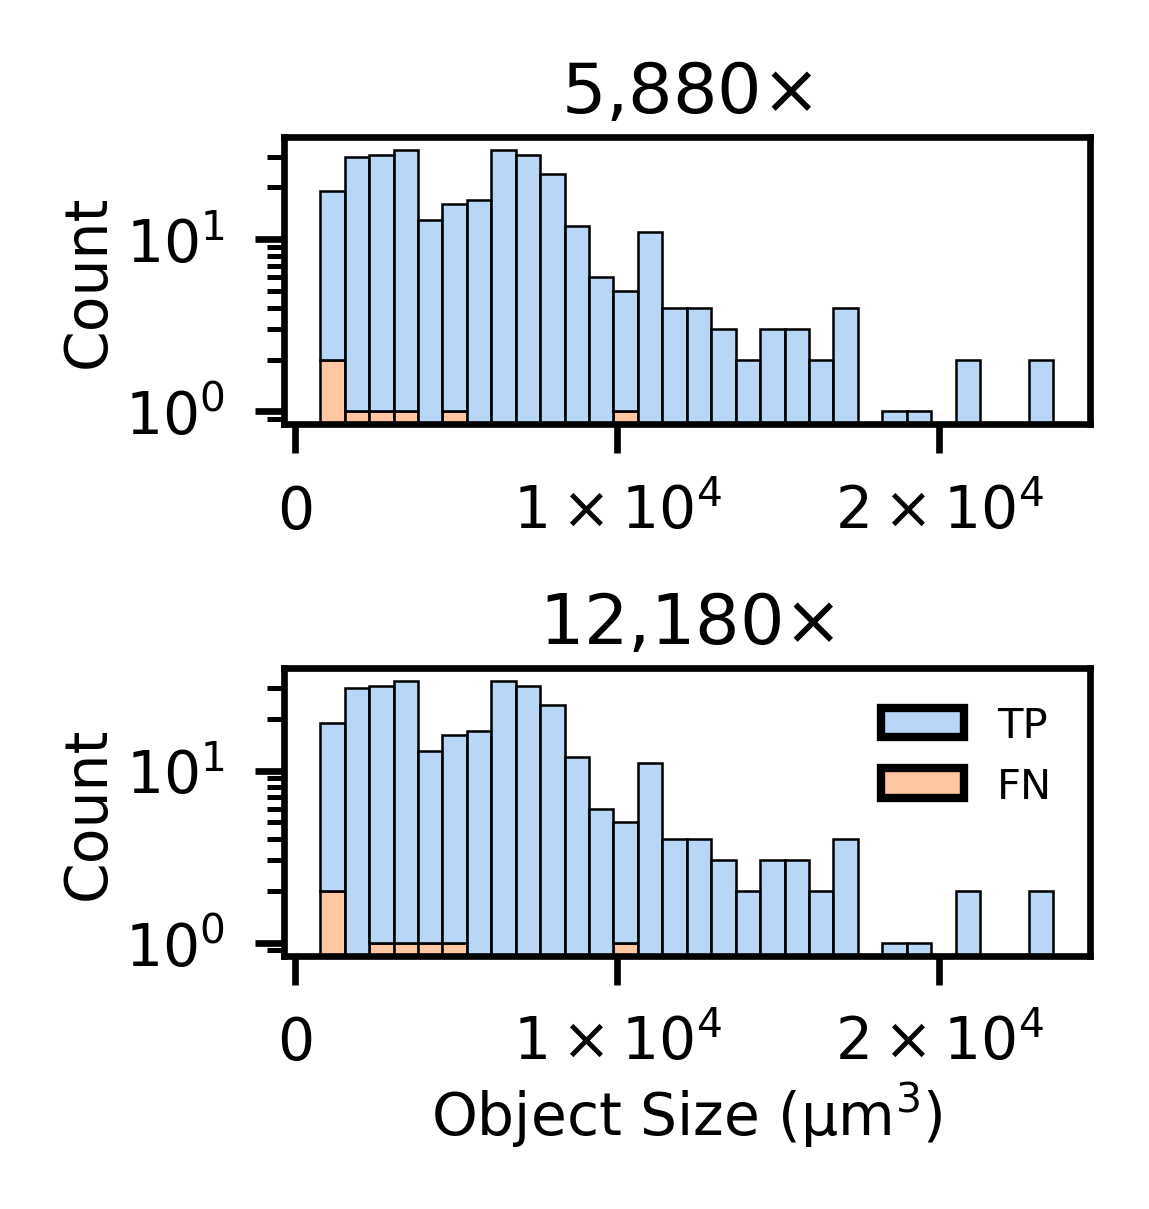

In [44]:
fig, axs  = plt.subplots(figsize=(1.8, 1.9), dpi=600, ncols=1, nrows=2, layout='constrained')
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
axs = axs.flat

sns.histplot(data=area_data[area_data['label']=='5880'], x="size", hue='type', stat="count", multiple="stack", palette="pastel",ax=axs[0], bins=30)
axs[0].legend([],[], frameon=False)
axs[0].set_xlabel('')
tmp = area_data[area_data['label']=='5880']
TP = len(tmp[tmp['type'] == 'TP'])
FP = len(tmp[tmp['type'] == 'FP'])
FN = len(tmp[tmp['type'] == 'FN'])
print(f"TP: {TP}, FP: {FP}, FN: {FN}")
print(f"TP: {TP/(TP+FP+FN)}, FP: {FP/(TP+FP+FN)}, FN: {FN/(TP+FP+FN)}")
# axs[0].set_xlabel('Object Size')
# axs[0].set_xticklabels('')

sns.histplot(data=area_data[area_data['label']=='12180'], x="size", hue='type', stat="count",  multiple="stack", palette="pastel", ax=axs[1], bins=30)
# axs[1].legend([],[], frameon=False)
legend = axs[1].get_legend()
handles = legend.legend_handles
legend.remove()
axs[1].legend(handles, ['TP', 'FN', 'FP'], loc="upper right", frameon=False, fontsize=5)
tmp = area_data[area_data['label']=='12180']
TP = len(tmp[tmp['type'] == 'TP'])
FP = len(tmp[tmp['type'] == 'FP'])
FN = len(tmp[tmp['type'] == 'FN'])
print(f"TP: {TP}, FP: {FP}, FN: {FN}")
print(f"TP: {TP/(TP+FP+FN)}, FP: {FP/(TP+FP+FN)}, FN: {FN/(TP+FP+FN)}")

axs[1].sharex(axs[0])
axs[1].sharey(axs[0])
axs[1].set_yscale('log')
axs[1].set_xlabel('Object Size (μm$^3$)')

axs[1].set_xticks([0, 10000, 20000])
axs[1].set_xticklabels([0, '$1\\times10^4$', '$2\\times 10^4$'])

# axs[1].set_yticks([1, 10, 100])
# axs[1].set_yticklabels([1, '$10$', '$100$'])

axs[0].set_title('5,880$\\times$')
axs[1].set_title('12,180$\\times$')

# sns.lineplot(y='Dice', x="Compression Ratio", data=toplot, ax=axs[2], linewidth=1, color=colors[6])

# axs[2].set_xscale('log')
# axs[2].set_xticks([10, 100, 500])
# axs[2].set_xticklabels([10, 100, 500])
# axs[2].set_yticks([0.9, 0.95, 1])
# axs[2].set_ylim(0.9, 1)

# fig.tight_layout()
fig.savefig('DRQ5_metrics_v3_5um.pdf')

TP: 305, FP: 0, FN: 7
TP: 0.9775641025641025, FP: 0.0, FN: 0.022435897435897436


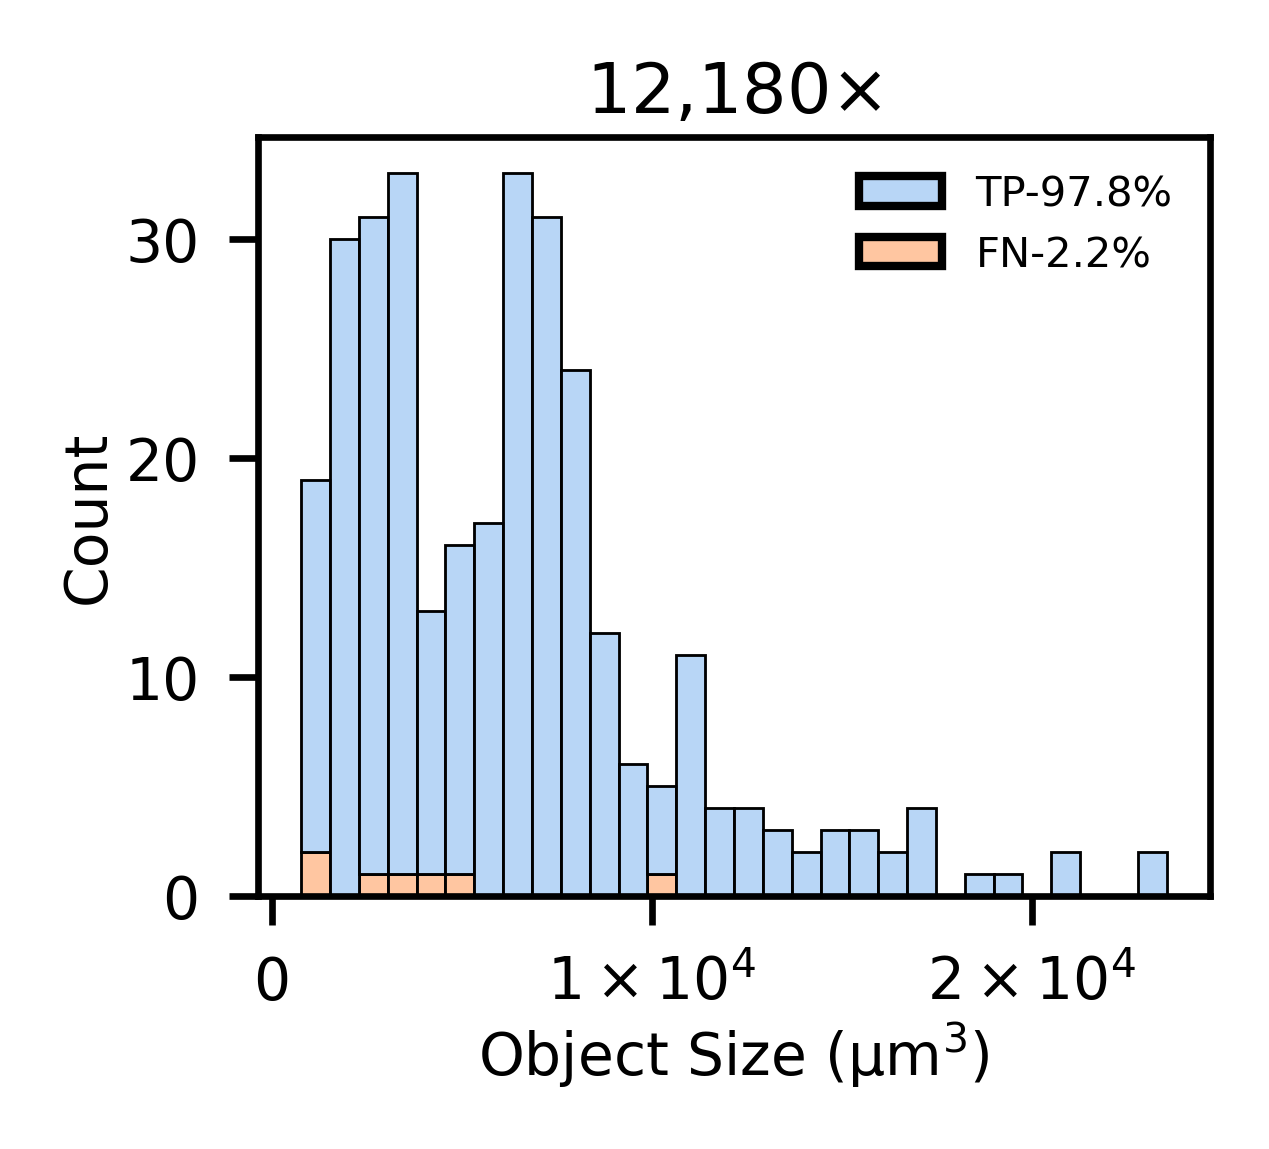

In [73]:
fig, axs  = plt.subplots(figsize=(2, 1.8), dpi=600, ncols=1, nrows=1, layout='constrained')
sns.set_palette('Set2')
colors = plt.colormaps['Set2'].colors
# axs = axs.flat

# sns.histplot(data=area_data[area_data['label']=='5880'], x="size", hue='type', stat="count", multiple="stack", palette="pastel",ax=axs[0], bins=30)
# axs[0].legend([],[], frameon=False)
# axs[0].set_xlabel('')
# tmp = area_data[area_data['label']=='5880']
# TP = len(tmp[tmp['type'] == 'TP'])
# FP = len(tmp[tmp['type'] == 'FP'])
# FN = len(tmp[tmp['type'] == 'FN'])
# print(f"TP: {TP}, FP: {FP}, FN: {FN}")
# print(f"TP: {TP/(TP+FP+FN)}, FP: {FP/(TP+FP+FN)}, FN: {FN/(TP+FP+FN)}")
# # axs[0].set_xlabel('Object Size')
# # axs[0].set_xticklabels('')

sns.histplot(data=area_data[area_data['label']=='12180'], x="size", hue='type', stat="count",  multiple="stack", palette="pastel", bins=30)
# axs[1].legend([],[], frameon=False)
legend = axs.get_legend()
handles = legend.legend_handles
legend.remove()
axs.legend(handles, ['TP-97.8%', 'FN-2.2%', 'FP-0.0%'], loc="upper right", frameon=False, fontsize=5)
tmp = area_data[area_data['label']=='12180']
TP = len(tmp[tmp['type'] == 'TP'])
FP = len(tmp[tmp['type'] == 'FP'])
FN = len(tmp[tmp['type'] == 'FN'])
print(f"TP: {TP}, FP: {FP}, FN: {FN}")
print(f"TP: {TP/(TP+FP+FN)}, FP: {FP/(TP+FP+FN)}, FN: {FN/(TP+FP+FN)}")

# axs.set_yscale('log')
axs.set_xlabel('Object Size (μm$^3$)')

axs.set_xticks([0, 10000, 20000])
axs.set_xticklabels([0, '$1\\times10^4$', '$2\\times 10^4$'])

# axs[1].set_yticks([1, 10, 100])
# axs[1].set_yticklabels([1, '$10$', '$100$'])

axs.set_title('12,180$\\times$')

# sns.lineplot(y='Dice', x="Compression Ratio", data=toplot, ax=axs[2], linewidth=1, color=colors[6])

# axs[2].set_xscale('log')
# axs[2].set_xticks([10, 100, 500])
# axs[2].set_xticklabels([10, 100, 500])
# axs[2].set_yticks([0.9, 0.95, 1])
# axs[2].set_ylim(0.9, 1)

# fig.tight_layout()
fig.savefig('DRQ5_metrics_v3_5um.pdf')